/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


Segundos: 6290.0634979999995
Iteraciones: 300484
Actualizaciones: 300484
Pérdida cuadrática: 25.290910076150897
N=33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


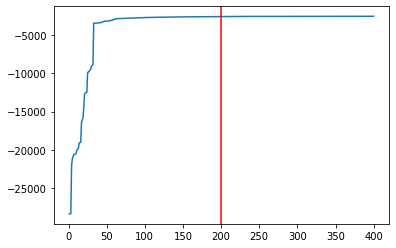

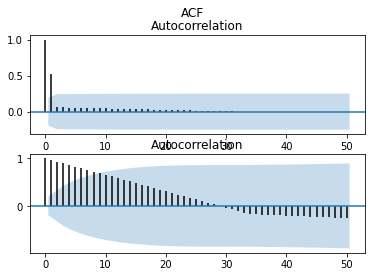

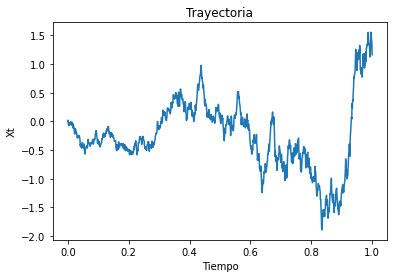

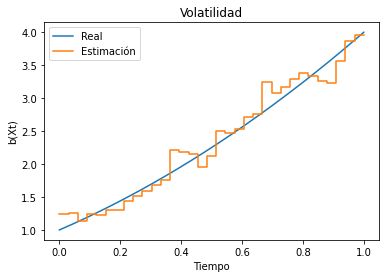

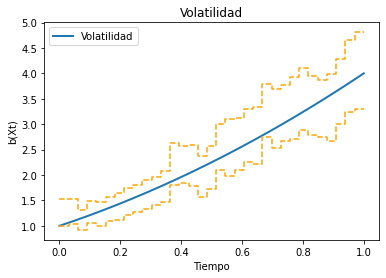

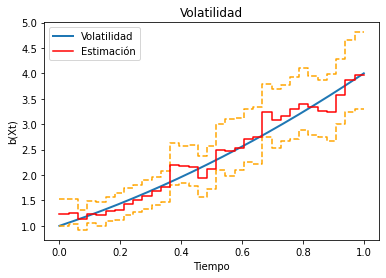

In [3]:
#Gibbs volatilidad
import numpy as np
import scipy as sp
import math
import time
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

tim1=time.clock()
s=57810
np.random.seed(s) # se fija la semilla

muestra=10000 # tamaño de la muestra con la que se aproximará
burn=200 # punto de burn-in
lag=30

#hiperparámetros
T=1.0
n=1000
m=30
ind=0
N=math.floor(n/m)
r=n-m*N
alfa=20.0
alfaz=20.0
alfa1=0.1

cont=0
cont_lag=1
indice=1

y0=0.0
lamt=T/n
W=np.random.normal(loc=0.0,scale=math.sqrt(lamt),size=n) # generación de normales para incrementos de movimiento browniano

def fun(yi,ti): #función de volatilidad de la SDE
  c=(ti+1)**2
  return c

cadenax=np.repeat(y0,(n+1))
b=np.repeat(0.0,(n+1))
yb=np.repeat(1.1,n)
for i in range(n):
  b[i]=fun(cadenax[i],(i*lamt))
  cadenax[i+1]=cadenax[i]+b[i]*W[i] # se utiliza Euler-Maruyama para trayectoria de solución de SDE
  yb[i]=cadenax[i+1]-cadenax[i] # se generan variables Y
b[n]=fun(cadenax[n],T)

y2=yb**2
obs=np.repeat(2.1,N) # vector de observaciones (variable Z)
bi=0
while bi<N:
  suma=0.0
  for i in range(m):
    suma+=y2[m*bi+i]
  obs[bi]=suma
  bi+=1
for i in range(r):
  obs[N-1]+=y2[i+bi*m]

theta=np.random.gamma(shape=1,scale=1,size=N) # se inicializa theta
zeta=np.random.gamma(shape=1,scale=1,size=N-1) # se inicializa zeta

x=np.repeat(0.0,2*N-1)
x=np.resize(x,(2*N-1,1)) # arreglo para guardar muestra pseudo-independiente

# se inicializan parámetros de theta y zeta
vec_alfa=np.repeat(1.0,N)
vec_beta=np.repeat(2.0,N)
vec_alfaz=np.repeat(3.0,N-1)
vec_betaz=np.repeat(4.0,N-1)
vec_alfa[0]=0.5*m+alfa1+alfaz
vec_beta[0]=0.5*n*obs[0]/T+alfaz/zeta[0]+alfa1
vec_alfa[N-1]=0.5*(m+r)+alfa
vec_beta[N-1]=0.5*n*obs[N-1]/T+alfa/zeta[N-2]
for j in range(N-2):
  vec_alfa[j+1]=0.5*m+alfa+alfaz
  vec_beta[j+1]=0.5*n*obs[j+1]/T+alfa/zeta[j]+alfaz/zeta[j+1]
  vec_alfaz[j]=alfaz+alfa
  vec_betaz[j]=alfa/theta[j+1]+alfaz/theta[j]
vec_alfaz[N-2]=alfaz+alfa
vec_betaz[N-2]=alfa/theta[N-1]+alfa/theta[N-2]

cadena=np.concatenate((theta,zeta))


def ver(x): # función para evaluar logverosimilitud
  res1=-(alfa1+1)*np.log(x[0])-alfa1/x[0]-0.5*(m+r)*np.log(x[N-1])-0.5*n*obs[N-1]/(T*x[N-1])
  for l in range(N-1):
    res1 += -0.5*(m*np.log(x[l])+n*obs[l]/(T*x[l]))
    res1 += -1*((alfa+alfaz+1)*np.log(x[l+N])+(alfa+1)*np.log(x[l+1])+alfaz*np.log(x[l])+alfa/(x[l+N]*x[l+1])+alfaz/(x[l]*x[l+N]))
  return res1

def uno(arg): # genera observación inversa gamma con parámetros de theta
  aleat=arg
  al=vec_alfa[aleat]
  bet=vec_beta[aleat]
  res=bet*sp.stats.invgamma.rvs(a=al,size=1)[0]
  ress=np.array([res,aleat])
  return ress

def dos(arg): # genera observación inversa gamma con parámetros de zeta
  aleat=arg
  al=vec_alfaz[aleat]
  bet=vec_betaz[aleat]
  res=bet*sp.stats.invgamma.rvs(a=al,size=1)[0]
  ress=np.array([res,aleat])
  return ress

def cero(arg):
  print("Error")
  exit()

def propuesta(arg,arg2): # genera observación inversa gamma con parámetros de theta o zeta
  switcher={
      0: uno,
      1: dos
  }
  func=switcher.get(arg,cero)
  return func(secu)

f=np.array([ver(cadena)]) # arreglo para guardar logverosimilitud
cadena=np.resize(cadena,(2*N-1,1))
secu=0 # entrada de vector de theta/zeta a simular
ind=0 # auxiliar para determinar si se simula theta o zeta
u=0
while indice<(muestra+1):
  if secu==N and ind==0:
    u=1 # se elegirán parámetros de zeta
    ind=1
    secu=0
  elif secu==(N-1) and ind==1:
    u=0 # se elegirán parámetros de theta
    ind=0
    secu=0
  y=propuesta(u,secu) # se genera propuesta
  secu+=1
  aux=np.resize(cadena[:,cont],(2*N-1,1)) # se obtiene última observación de la cadena
  aux[int(y[1]+u*N),0]=y[0] # se actualiza una entrada de theta/zeta
  theta=aux[0:N,0]
  zeta=aux[N:(2*N-1),0]
  vec_beta[0]=0.5*n*obs[0]/T+alfaz/zeta[0]+alfa1 # se actualizan parámetros de theta
  vec_beta[N-1]=0.5*n*obs[N-1]/T+alfa/zeta[N-2] # se actualizan parámetros de theta
  for j in range(N-2):
    vec_beta[j+1]=0.5*n*obs[j+1]/T+alfa/zeta[j]+alfaz/zeta[j+1] # se actualizan parámetros de theta
    vec_betaz[j]=alfa/theta[j+1]+alfaz/theta[j] # se actualizan parámetros de zeta
  vec_betaz[N-2]=alfa/theta[N-1]+alfa/theta[N-2] # se actualizan parámetros de zeta
  cont+=1
  if cont>burn and (cont%(2*N-1))==0:
    cont_lag+=1
  if (cont_lag%lag)==0:
    x=np.concatenate((x,aux),axis=1) # se guarda muestra pseudo-independiente
    indice+=1
  cadena=np.concatenate((cadena,aux),axis=1)
  f=np.concatenate((f,np.array([ver(cadena[:,cont])]))) # se guarda logverosimilitud
lim=min(400,cont)
tt=np.linspace(start=1,stop=lim,num=lim,dtype=int)
t=np.linspace(0,T,n+1)
t2=np.linspace(0,T,num=(N+1))
x=np.sqrt(x)
espp=np.mean(x[0:N,:],axis=1)
esp2=np.repeat(5.4,(N+1))
for i in range(N):
  esp2[i+1]=espp[i]
esp2[0]=espp[0]


tim2=time.clock()
timf=tim2-tim1
err=0.0 # error
ccc=0
for i in range(N):
  for j in range(m):
    err+=(b[ccc+1]-espp[i])**2
    ccc+=1
for i in range(r):
  err+=(b[ccc+1]-espp[N-1])**2
  ccc+=1

perc=np.ones((N+1,2))*5.3
perc[0,:]=np.percentile(x[0,:],np.array([2.5,97.5]))
for i in range(N):
  perc[i+1,:]=np.percentile(x[i,:],np.array([2.5,97.5]))

print("Segundos: ",timf,sep="")
print("Iteraciones: ", cont, sep="")
print("Actualizaciones: ", cont, sep="")
print("Pérdida cuadrática: ",err,sep="")
print("N=",N,sep="")

plt.plot(tt,f[1:lim+1])
plt.axvline(x=burn,color='r')
plt.show()

fig, axs = plt.subplots(2)
fig.suptitle('ACF')
fig = plot_acf(cadena[1,0:100],ax=axs[0],marker="",lags=50)
fig = plot_acf(cadena[N,0:100],ax=axs[1],marker="",lags=50)
plt.show()

plt.plot(t,cadenax)
plt.xlabel("Tiempo")
plt.ylabel("Xt")
plt.title("Trayectoria")
plt.show()

plt.plot(t,b,label="Real")
plt.step(t2,esp2,label="Estimación")
plt.xlabel("Tiempo")
plt.ylabel("b(Xt)")
plt.title("Volatilidad")
plt.legend()
plt.show()

plt.plot(t,b,label="Volatilidad",linewidth=2)
plt.step(t2,perc[:,0],linestyle='dashed',color="orange")
plt.step(t2,perc[:,1],linestyle='dashed',color="orange")
plt.xlabel("Tiempo")
plt.ylabel("b(Xt)")
plt.title("Volatilidad")
plt.legend()
plt.show()

plt.plot(t,b,label="Volatilidad",linewidth=2)
plt.step(t2,perc[:,0],linestyle='dashed',color="orange")
plt.step(t2,perc[:,1],linestyle='dashed',color="orange")
plt.step(t2,esp2,label="Estimación",color='red')
plt.xlabel("Tiempo")
plt.ylabel("b(Xt)")
plt.title("Volatilidad")
plt.legend()
plt.show()

